In [2]:
# Data Processing Libraries
import pandas as pd
import os
import csv
import numpy as np
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt

# Model Libraries 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import regularizers

2023-12-04 22:48:37.913806: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# View Singular Sample Data (Example)
datapath = "data/processed_data/c31900a4-5dcd-4022-97ac-638e86e889e4/TCGA-BRCA.52dbb525-a0ad-4dce-bb51-650f97510c6e.absolute_liftover.gene_level_copy_number.v36.tsv" 
df = pd.read_csv(datapath, sep='\t')
df


,gene_id,gene_name,chromosome,start,end,copy_number,min_copy_number,max_copy_number
0,ENSG00000223972.5,DDX11L1,chr1,11869,14409,NaN,NaN,NaN
1,ENSG00000227232.5,WASH7P,chr1,14404,29570,NaN,NaN,NaN
2,ENSG00000278267.1,MIR6859-1,chr1,17369,17436,NaN,NaN,NaN
3,ENSG00000243485.5,MIR1302-2HG,chr1,29554,31109,NaN,NaN,NaN
4,ENSG00000284332.1,MIR1302-2,chr1,30366,30503,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
60618,ENSG00000124334.17_PAR_Y,IL9R,chrY,57184101,57197337,NaN,NaN,NaN
60619,ENSG00000270726.6_PAR_Y,AJ271736.1,chrY,57190738,57208756,NaN,NaN,NaN
60620,ENSG00000185203.12_PAR_Y,WASIR1,chrY,57201143,57203357,NaN,NaN,NaN
60621,ENSG00000182484.15_PAR_Y,WASH6P,chrY,57207346,57212230,NaN,NaN,NaN


### Load, Clean, and Process Data

In [4]:
# Map Case ID to Primary Diagnosis and Gender
case_info = {}
label_df = pd.read_csv("data/processed_labels/clinical.tsv", sep='\t')[["case_id", "gender", "primary_diagnosis"]]
for i, row in label_df.iterrows(): 
    case_info[row.case_id] = {"gender": row.gender, "primary_diagnosis": row.primary_diagnosis}


In [22]:
# FUNCTION: Encode Input Data into Numeric Array Data 
#          [note - final array only includes gene length, chromosome num. and CNV]
def encode_data(datapath): 
    # Load DF
    df = pd.read_csv(datapath, sep='\t') 

    # Additional Processing
    df = df.drop(columns=['gene_name', 'gene_id', 'max_copy_number', 'min_copy_number'], axis=1)
    df = df.fillna(0)
    df["gene_length"] = abs(df.start - df.end)

    # Perform one-hot encoding for categorical variables (gene_name and chromosome)
    df = pd.get_dummies(df, columns=['chromosome']).astype(int)

    # Clean and Normalize 
    df = df.drop(['start', 'end'], axis=1)
    col_min = df['gene_length'].min()
    col_max = df['gene_length'].max()
    df['gene_length'] = (df['gene_length'] - col_min) / (col_max - col_min)

    # Convert to Array 
    arr_data = df.to_numpy()

    return arr_data


# Example ----------------------------------------------------------------------------------
case_id = "c31900a4-5dcd-4022-97ac-638e86e889e4"
file_name = "TCGA-BRCA.52dbb525-a0ad-4dce-bb51-650f97510c6e.ascat3.gene_level_copy_number.v36.tsv"
datapath = "data/processed_data/" + case_id + "/" + file_name

# Set up Labels, x = matrix(df) and y = prognosis
gender = case_info[case_id]["gender"]
x = encode_data(datapath)
y = case_info[case_id]["primary_diagnosis"]

print(y) 
print(gender)

np.shape(x)


Infiltrating duct carcinoma, NOS
female


(60623, 26)

In [23]:
# Encode All Processed Data 
gender_list = []
x_list = []
y_list = [] 

# data cleaning tracker 
cases_discarded = []

for case_id in tqdm(os.listdir("data/processed_data")): 
    # CLEAN DATA: Discard data pt.'s with no label 
    if case_id not in case_info: 
        cases_discarded.append(case_id)
        continue

    # Get Diagnosis
    primary_diagnosis = case_info[case_id]["primary_diagnosis"]
    gender = case_info[case_id]["gender"]

    # Encode Data 
    for file_name in os.listdir("data/processed_data/" + case_id): 
        datapath = "data/processed_data/" + case_id + "/" + file_name 
        x_list.append(encode_data(datapath))

        y_list.append(primary_diagnosis)
        gender_list.append(gender)

print("\n----- CLEANED DATA ------") 
print("Cases Discarded:", cases_discarded)
print("\n-------------------------")

# Write Out to CSV File 
data_list = zip(gender_list, x_list, y_list)
model_data_df = pd.DataFrame(data_list, columns=["gender", "sample_data", "label"])
# model_data_df.to_csv("model_data.tsv", sep='\t', index=False)
model_data_df.to_pickle("data/model_data.pkl")
model_data_df

100%|██████████| 319/319 [01:21<00:00,  3.93it/s]



----- CLEANED DATA ------
Cases Discarded: []

-------------------------


,gender,sample_data,label
0,female,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
1,female,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
2,female,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
3,female,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
4,female,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
...,...,...,...
495,female,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...",Mucinous adenocarcinoma
496,female,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
497,female,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
498,female,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"


### Split Model Data
Note: can load cached data here

In [24]:
# Test Loading Data
model_data_df = pickle.load(open('data/model_data.pkl', 'rb'))
model_data_df

,gender,sample_data,label
0,female,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
1,female,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
2,female,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
3,female,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
4,female,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
...,...,...,...
495,female,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...",Mucinous adenocarcinoma
496,female,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
497,female,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
498,female,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"


In [25]:
# SPLIT AND PRE-PROCESS DATA 

# Convert x to numpy array 
x = np.rollaxis(np.dstack(model_data_df.sample_data), -1)

# Convert y labels to one-hot encoded format |--> numpy array 
y = np.array(model_data_df.label)
num_classes = len(np.unique(y))
label_encoder = LabelEncoder()
y_numerical = label_encoder.fit_transform(y)
y_one_hot = to_categorical(y_numerical, num_classes=num_classes)
y = np.rollaxis(np.dstack(y_one_hot), -1)

# Split the data into training and testing sets
x_train, x_val_and_test, y_train, y_val_and_test = train_test_split(x, y_one_hot, test_size=0.7, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_val_and_test, y_val_and_test, test_size=0.5, random_state=42)

# Convert NumPy arrays to TensorFlow tensors
x_train_tf = tf.convert_to_tensor(x_train, dtype=tf.float32)
x_val_tf = tf.convert_to_tensor(x_val, dtype=tf.float32)
x_test_tf = tf.convert_to_tensor(x_test, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_val_tf = tf.convert_to_tensor(y_val, dtype=tf.float32)
y_test_tf = tf.convert_to_tensor(y_test, dtype=tf.float32)


### Train Basic DNN Model

In [26]:
# TRAIN NEURAL NETWORK

# Basic DNN Model 
reg_rate = 0.1
model = Sequential([
    Flatten(input_shape=(60623, 26)),  # Flattening the input
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(reg_rate)),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(reg_rate)),
    Dense(num_classes, activation='softmax')  # Output layer with softmax for multi-class
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=40, batch_size=32, validation_data=(x_val, y_val))


Epoch 1/40
5/5 [==============================] - 24s 4s/step - loss: 66.6677 - accuracy: 0.3467 - val_loss: 111.8600 - val_accuracy: 0.1543
Epoch 2/40
5/5 [==============================] - 7s 1s/step - loss: 69.5227 - accuracy: 0.6667 - val_loss: 121.4451 - val_accuracy: 0.7543
Epoch 3/40
5/5 [==============================] - 8s 2s/step - loss: 58.4907 - accuracy: 0.5467 - val_loss: 97.6670 - val_accuracy: 0.7543
Epoch 4/40
5/5 [==============================] - 8s 2s/step - loss: 53.4189 - accuracy: 0.7800 - val_loss: 109.6114 - val_accuracy: 0.7543
Epoch 5/40
5/5 [==============================] - 8s 2s/step - loss: 43.6610 - accuracy: 0.6800 - val_loss: 97.4333 - val_accuracy: 0.1543
Epoch 6/40
5/5 [==============================] - 8s 2s/step - loss: 40.7150 - accuracy: 0.6067 - val_loss: 99.3994 - val_accuracy: 0.7543
Epoch 7/40
5/5 [==============================] - 7s 1s/step - loss: 43.4447 - accuracy: 0.7533 - val_loss: 88.8840 - val_accuracy: 0.3600
Epoch 8/40
5/5 [=======

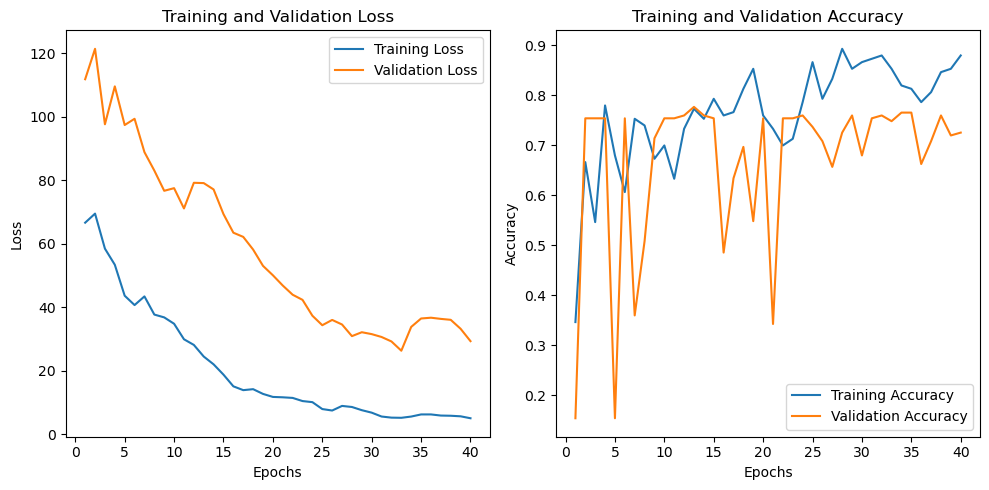

In [27]:
# PLOT MODEL PROGRESS

# Get training history
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(training_loss) + 1)

# Plotting loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [29]:
# Check Test Performance 
evaluation = model.evaluate(x_test, y_test)

# 'evaluation' will contain the loss value and accuracy
loss = evaluation[0]
accuracy = evaluation[1]

print(f"Loss on test data: {loss}")
print(f"Accuracy on test data: {accuracy}")


6/6 [==============================] - 1s 81ms/step - loss: 40.6009 - accuracy: 0.7314
Loss on test data: 40.600914001464844
Accuracy on test data: 0.7314285635948181
